# Imports

In [1]:
import numpy as np
import pandas as pd
from pulsee.operators import * 
from pulsee.simulation import *
import qutip as qt
import matplotlib.pyplot as plt

# Parameters

In [2]:
qn = 3/2
gr = 1.
b0 = 1.
e2qQ = 0.5

spin_par = {'quantum number' : qn,
			'gamma/2pi' : gr}

zeem_par = {'field magnitude' : b0,
			'theta_z' : 0,
			'phi_z' : 0}

In [3]:
etas = np.linspace(0, 1, 2)
# etas = [0]

# Simulation
Define simulation code which we will run with different solvers:

In [4]:
def simulate(solver):

    # Fourier transforms for each eta
    fts = []

    for eta in etas:
        quad_par = {'coupling constant' : e2qQ,
                    'asymmetry parameter' : eta,
                    'alpha_q' : 0.,
                    'beta_q' : 0.,
                    'gamma_q' : 0.}

        b1 = 1e-1*b0
        
        mode = pd.DataFrame([(1, b1, 0., math.pi/2, 0)], 
                            columns=['frequency', 'amplitude', 'phase', 'theta_p', 'phi_p'])

        spin, h_unperturbed, dm_initial = nuclear_system_setup(spin_par, quad_par=quad_par, 
                                            zeem_par=zeem_par, initial_state='canonical', temperature=1e-3)
        
        ix, iy, iz = qt.spin_J_set(3 / 2)
#         dm_initial = iz
        print(np.round(dm_initial.full(), 3))
        opts = Options(atol=1e-10, rtol=1e-10, rhs_reuse=False, nsteps=16000)
        dm_evolved = evolve(spin, h_unperturbed, dm_initial, solver=solver, \
                            mode=mode, pulse_time = 1 / (4 * math.sqrt(3) *  gr * b1), \
                            picture='IP', n_points=10, opts=opts)

        print(np.round(dm_evolved.full(), 3))
        t, FID = FID_signal(spin, h_unperturbed, dm_evolved, acquisition_time=3200, \
                            T2=800, reference_frequency=0, n_points=5)


        f, ft = fourier_transform_signal(FID, t, padding=0)
        fts.append([eta, f, ft, t, FID])
    return fts

# Plots

Run simulations with Magnus solve

In [5]:
fts_magnus = simulate('magnus')

[[0.267+0.j 0.   +0.j 0.   +0.j 0.   +0.j]
 [0.   +0.j 0.257+0.j 0.   +0.j 0.   +0.j]
 [0.   +0.j 0.   +0.j 0.245+0.j 0.   +0.j]
 [0.   +0.j 0.   +0.j 0.   +0.j 0.231+0.j]]
[[ 0.267+0.j    -0.001+0.j    -0.   -0.j    -0.   +0.j   ]
 [-0.001-0.j     0.257+0.j     0.001+0.j    -0.   +0.j   ]
 [-0.   +0.j     0.001-0.j     0.245+0.j    -0.   -0.001j]
 [-0.   -0.j    -0.   -0.j    -0.   +0.001j  0.231+0.j   ]]
[[ 0.267+0.j  0.   +0.j -0.001+0.j  0.   +0.j]
 [ 0.   +0.j  0.257+0.j  0.   +0.j -0.001+0.j]
 [-0.001+0.j  0.   +0.j  0.245+0.j  0.   +0.j]
 [ 0.   +0.j -0.001+0.j  0.   +0.j  0.231+0.j]]
[[ 0.267+0.j    -0.001+0.j    -0.001-0.j     0.   -0.j   ]
 [-0.001-0.j     0.257+0.j     0.001+0.j    -0.001+0.j   ]
 [-0.001+0.j     0.001-0.j     0.245+0.j    -0.   -0.001j]
 [ 0.   +0.j    -0.001-0.j    -0.   +0.001j  0.231+0.j   ]]


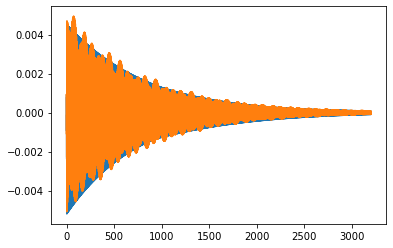

In [6]:
fig, ax = plt.subplots() 
for eta, f, ft, t, fid in fts_magnus: 
	plt.plot(t, np.real(fid))

# ax.set_xlim(0, 0.2)
# fig.show()

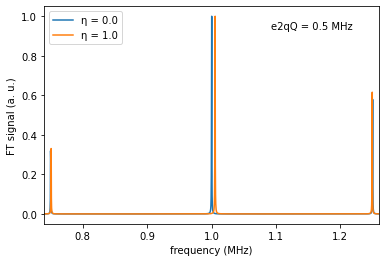

In [16]:
fig, ax = plt.subplots()
for eta, f, ft, t, fid in fts_magnus:
    plt.plot(f, (np.absolute(ft)/np.max(np.absolute(ft)))**2, label="\N{GREEK SMALL LETTER ETA} = " + str(np.round(eta, 2)))

plt.figtext(.65, .8, 'e2qQ = ' + str(np.round(e2qQ, 3)) + ' MHz')
plt.legend(loc='upper left')
plt.xlabel("frequency (MHz)")    
plt.ylabel("FT signal (a. u.)")
plt.xlim(0.74, 1.26)
plt.show()

Plot & solve mesolve solution QuTiP's [master equation solver](https://qutip.org/docs/latest/modules/qutip/mesolve.html#mesolve)::

In [8]:
fts_mesolve = simulate('mesolve')

[[0.267+0.j 0.   +0.j 0.   +0.j 0.   +0.j]
 [0.   +0.j 0.257+0.j 0.   +0.j 0.   +0.j]
 [0.   +0.j 0.   +0.j 0.245+0.j 0.   +0.j]
 [0.   +0.j 0.   +0.j 0.   +0.j 0.231+0.j]]
[[ 0.267-0.j    -0.001-0.j     0.   -0.j    -0.   -0.j   ]
 [-0.001+0.j     0.257+0.j     0.001-0.j     0.   -0.j   ]
 [ 0.   +0.j     0.001+0.j     0.245-0.j    -0.   +0.001j]
 [-0.   +0.j     0.   +0.j    -0.   -0.001j  0.231+0.j   ]]
[[ 0.267+0.j  0.   +0.j -0.001+0.j  0.   +0.j]
 [ 0.   +0.j  0.257+0.j  0.   +0.j -0.001+0.j]
 [-0.001+0.j  0.   +0.j  0.245+0.j  0.   +0.j]
 [ 0.   +0.j -0.001+0.j  0.   +0.j  0.231+0.j]]
[[ 0.267-0.j    -0.001-0.j    -0.001-0.j     0.   +0.j   ]
 [-0.001+0.j     0.257+0.j     0.001-0.j    -0.001-0.j   ]
 [-0.001+0.j     0.001+0.j     0.245+0.j    -0.   +0.001j]
 [ 0.   -0.j    -0.001+0.j    -0.   -0.001j  0.231-0.j   ]]


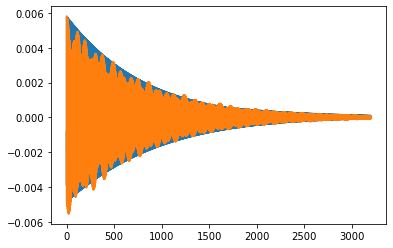

In [9]:
fig, ax = plt.subplots() 
for eta, f, ft, t, fid in fts_mesolve: 
	plt.plot(t, np.imag(fid))

# ax.set_xlim(0, 0.2)

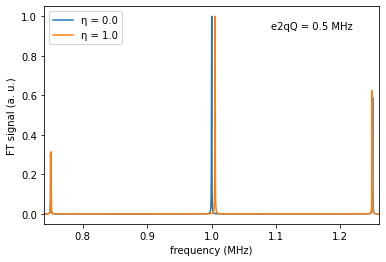

In [15]:
fig, ax = plt.subplots()
for eta, f, ft, t, fid in fts_mesolve:
    plt.plot(f, (np.absolute(ft)/np.max(np.absolute(ft)))**2, label="\N{GREEK SMALL LETTER ETA} = " + str(np.round(eta, 2)))

plt.figtext(.65, .8, 'e2qQ = ' + str(np.round(e2qQ, 3)) + ' MHz')
plt.legend(loc='upper left')
plt.xlabel("frequency (MHz)")    
plt.ylabel("FT signal (a. u.)")
plt.xlim(0.74, 1.26)
plt.show()


Simulate with exact diagonalization approach:

In [11]:
fts_ed = [] 

for eta in etas:
	quad_par = {'coupling constant' : e2qQ,
				'asymmetry parameter' : eta,
				'alpha_q' : 0.,
				'beta_q' : 0.,
				'gamma_q' : 0.}

	spin, h_unperturbed, dm_initial = nuclear_system_setup(spin_par, quad_par=quad_par, 
										zeem_par=zeem_par, initial_state='canonical')

    
    
	t = np.linspace(0, 3200, 5*3200) # 50 second acquisition time, 1000 data points

	ix, iy, iz = qt.spin_J_set(3 / 2)
	dm_initial = iz
	rot_dm = apply_rot_pulse(dm_initial, np.pi/2, ix) # rotate about x axis
	dm_evolved, e_ops = ed_evolve(h_unperturbed, rot_dm, spin, t, e_ops=[], fid=True, par=True, T2=800)

	FID = e_ops[0]

	f, ft = fourier_transform_signal(FID, t, padding=0)
	fts_ed.append([eta, f, ft])


Plot exact diagonalization solution:

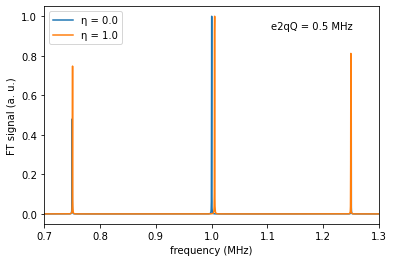

In [14]:
fig, ax = plt.subplots()
for eta, f, ft in fts_ed:
    plt.plot(f, (np.absolute(ft)/np.max(np.absolute(ft)))**2, label="\N{GREEK SMALL LETTER ETA} = " + str(np.round(eta, 2)))

plt.figtext(.65, .8, 'e2qQ = ' + str(np.round(e2qQ, 3)) + ' MHz')
plt.legend(loc='upper left')
plt.xlabel("frequency (MHz)")    
plt.ylabel("FT signal (a. u.)")
plt.xlim(0.7, 1.3)
plt.show()
